## Recolección de datos

Usamos yahoo finance para recolectar datos históricos

In [2]:
import yfinance as yf
import pandas as pd

# Lista de tickers
tickers = ['BIMBOA.MX', 'CEMEXCPO.MX', 'GMEXICOB.MX', 'WALMEX.MX', 'FEMSAUBD.MX', 'ALFAA.MX',
           'ASURB.MX', 'OMAB.MX', 'TLEVISACPO.MX', 'LIVEPOLC-1.MX']

# Descargar datos históricos de los últimos 6 años
data = yf.download(tickers, start='2018-01-01', end='2024-01-01')

# Filtrar solo los precios de cierre y de alta y baja
prices = data['Adj Close']
high_prices = data['High']
low_prices = data['Low']


[*********************100%%**********************]  10 of 10 completed


## Cálculo de estadísticas

Calculamos los movimientos finales y los rendimientos diarios:

In [3]:
# Movimientos finales diarios
daily_movements = high_prices - low_prices

# Rendimientos diarios
returns = prices.pct_change().dropna()

# Concatenar ambos en un solo DataFrame para el análisis de clúster
stats = pd.concat([daily_movements.mean(), returns.mean()], axis=1)
stats.columns = ['Daily Movements', 'Daily Returns']


## Análisis del clúster

Utilizamos K-Means para realizar el análisis de clúster:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


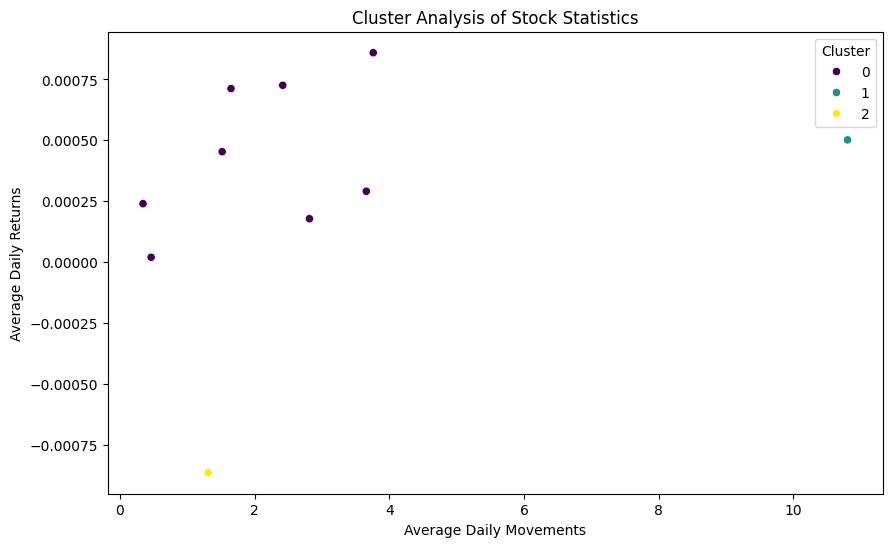

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Estandarizar las estadísticas
scaler = StandardScaler()
stats_scaled = scaler.fit_transform(stats)

# Aplicar K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(stats_scaled)

# Añadir etiquetas de clúster a las estadísticas
stats['Cluster'] = clusters

# Visualización
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stats['Daily Movements'], y=stats['Daily Returns'], hue=stats['Cluster'], palette='viridis')
plt.title('Cluster Analysis of Stock Statistics')
plt.xlabel('Average Daily Movements')
plt.ylabel('Average Daily Returns')
plt.show()


## Simulación de Monte Carlo y Frontera Eficiente

Usaremos la simulación de Monte Carlo para calcular la frontera eficiente y el índice de Sharpe:

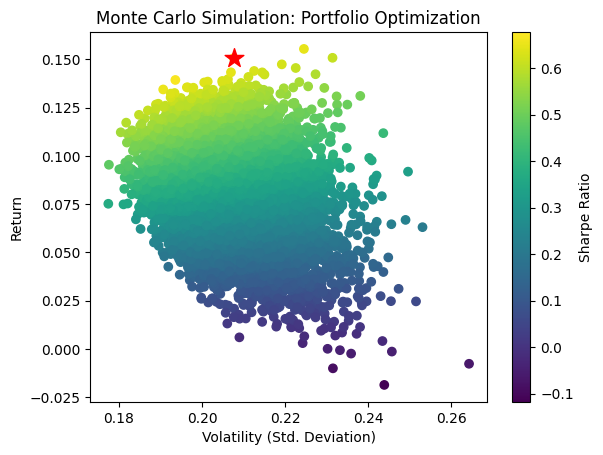

Max Sharpe Ratio: 0.6771088984410996
Optimal Weights: [0.02132428 0.01940583 0.29853428 0.00287681 0.04033407 0.27912353
 0.10271306 0.10124838 0.0051841  0.12925566]


In [5]:
import numpy as np

# Número de portafolios a simular
num_portfolios = 10000

# Preparar arrays para almacenar resultados
results = np.zeros((3, num_portfolios))
weights_record = []

# Datos de rendimientos esperados y matriz de covarianza
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.01

# Simulación de Monte Carlo
for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)

    portfolio_return = np.sum(weights * mean_returns) * 252
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    results[0,i] = portfolio_return
    results[1,i] = portfolio_stddev
    results[2,i] = (portfolio_return - risk_free_rate) / portfolio_stddev

# Convertir resultados a DataFrame
results_frame = pd.DataFrame(results.T, columns=['Return', 'StdDev', 'Sharpe'])

# Encontrar el portafolio con el índice de Sharpe más alto
max_sharpe_idx = results_frame['Sharpe'].idxmax()
optimal_weights = weights_record[max_sharpe_idx]
max_sharpe_portfolio = results_frame.loc[max_sharpe_idx]

# Frontera eficiente
plt.scatter(results_frame['StdDev'], results_frame['Return'], c=results_frame['Sharpe'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_portfolio[1], max_sharpe_portfolio[0], marker='*', color='r', s=200)
plt.title('Monte Carlo Simulation: Portfolio Optimization')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Return')
plt.show()

print(f"Max Sharpe Ratio: {max_sharpe_portfolio['Sharpe']}")
print(f"Optimal Weights: {optimal_weights}")


## Conculsión

**Análisis de Clúster**

Las empresas se agrupan en diferentes clústeres según sus movimientos diarios y rendimientos, indicando que hay diferentes comportamientos de mercado entre ellas.

**Simulación de Monte Carlo y Frontera Eficiente**

La simulación de Monte Carlo permite identificar la combinación óptima de activos para maximizar el índice de Sharpe.
Los pesos óptimos del portafolio nos indican en qué proporción invertir en cada activo para obtener el mejor rendimiento ajustado por riesgo.

Esto proporciona una visión clara de cómo se agrupan las empresas y cómo podemos optimizar un portafolio usando la simulación de Monte Carlo y la teoría de Markowitz.